In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import time
import random
import glob

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dst
from torchvision.io import read_image
from torchvision.transforms import v2
from torch.utils.data import DataLoader

# seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [20]:
# settings
batch_size = 128*4 # 512

# data
dataroot = "/export/space0/kanayama-r/semi/uec-semi/data/CelebA/Img"

def only_img_celeba(path):
    # dirname(path) の basename が "img_celeba" だけ通す
    return os.path.basename(os.path.dirname(path)) == "img_celeba"

dataset = dst.ImageFolder(
    root=dataroot,
    transform=v2.Compose([
        v2.CenterCrop(178),
        v2.Resize(28),
        v2.Grayscale(num_output_channels=1),
        v2.ToTensor(),
        # v2.Normalize([0.5]*3, [0.5]*3) # [-1,1] に正規化（GANの場合多い）
        v2.Normalize([0.5], [0.5])
    ]),
    is_valid_file=only_img_celeba,
    allow_empty=True,  
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

/home/yanai-lab/kanayama-r/.conda/envs/myenv/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [21]:
len(dataset)

202599

In [2]:
class Generator(nn.Module): # nn.Moduleは継承しなくてもいいけど一応
    def __init__(self, z_dim=100, img_dim=28*28):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, img_dim),
            nn.Tanh() # range[-1,1]
        )
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, img_dim=28*28):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim, 256),
            nn.LeakyReLU(0.2, True), # Dが早く飽和して学習しなくなるのを防ぐ
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
# exp
G = nn.DataParallel(Generator()).to(device)
D = nn.DataParallel(Discriminator()).to(device)

opt_G = torch.optim.Adam(G.parameters(), lr=2e-4)
opt_D = torch.optim.Adam(D.parameters(), lr=2e-4)

criterion = nn.BCELoss()

# ノイズ
z = torch.randn(batch_size, 100, device=device)

# learning
epochs = 100
z_dim = 100
for epoch in range(epochs):
    total_loss_D = 0
    total_loss_G = 0
    for real_imgs, _ in dataloader:
        real = real_imgs.view(real_imgs.size(0), -1).to(device) #[b,img_dim]

        # 1.Discriminator更新
        D.zero_grad()
        real_labels = torch.ones(real.size(0),1, device=device) #本物ラベル
        pred_real = D(real)
        loss_real = criterion(pred_real, real_labels)

        # 偽物生成
        z = torch.randn(real.size(0), z_dim, device=device)
        fake = G(z).detach()
        fake_labels = torch.zeros(real.size(0),1, device=device)
        pred_fake = D(fake)
        loss_fake = criterion(pred_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        opt_D.step()
        total_loss_D += loss_D

        # 2.Generator更新
        G.zero_grad()
        z2 = torch.randn(real.size(0), z_dim, device=device)
        fake2 = G(z2)
        pred2 = D(fake2)
        loss_G = criterion(pred2, torch.ones_like(pred2))
        loss_G.backward()
        opt_G.step()
        total_loss_G += loss_G

    avg_loss_D = total_loss_D / len(dataloader)
    avg_loss_G = total_loss_G / len(dataloader)
    print(f"epoch: {epoch+1}, loss_D: {avg_loss_D:.3f}, loss_G: {avg_loss_G:.3f}")

epoch: 1, loss_D: 0.621, loss_G: 1.900
epoch: 2, loss_D: 0.475, loss_G: 1.716


In [ ]:
# 検証
G.eval()

/tmp/ipykernel_1161876/3898387827.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load("6_1_gan.pth", map_location=device))


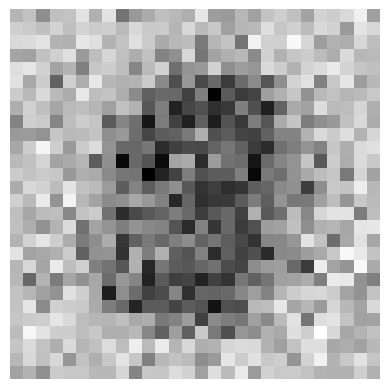

In [19]:
# 読み込み
G = Generator(z_dim=100, img_dim=28*28).to(device)
G.load_state_dict(torch.load("6_1_gan.pth", map_location=device))
G = nn.DataParallel(G)

# 検証
G.eval()
with torch.no_grad():
    z = torch.randn(1, 100, device=device)
    fake_imgs = G(z)                # → Tensor [16, img_dim]
    fake_imgs = fake_imgs.view(1, 1, 28, 28)
    fake_imgs = fake_imgs[0,0].cpu().numpy()

# 可視化
plt.imshow(fake_imgs, cmap='gray')
plt.axis('off')
plt.show()